In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Conv1D, GlobalMaxPooling1D
from transformers import BertTokenizer, TFBertForSequenceClassification
import tensorflow as tf

In [ ]:
import requests
from bs4 import BeautifulSoup
import json
import pandas as pd

headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3'}

# Function to get product reviews from BestBuy
def get_bestbuy_reviews(product_url):
    response = requests.get(product_url, headers=headers)
    if response.status_code != 200:
        print(f"Failed to fetch page, status code: {response.status_code}")
        return

    soup = BeautifulSoup(response.content, 'html.parser')

    # Extract reviews data from JSON embedded in the HTML
    scripts = soup.find_all('script', type='application/ld+json')
    reviews = []

    for script in scripts:
        try:
            data = json.loads(script.string)
            if isinstance(data, dict) and 'review' in data:
                reviews.extend(data['review'])
        except json.JSONDecodeError:
            pass

    # Prepare the data
    extracted_reviews = []
    for review in reviews:
        extracted_reviews.append({
            'author': review.get('author', {}).get('name', 'N/A'),
            'rating': review.get('reviewRating', {}).get('ratingValue', 'N/A'),
            'date': review.get('datePublished', 'N/A'),
            'reviewText': review.get('description', 'N/A'),
        })

    # Save data to a DataFrame
    df = pd.DataFrame(extracted_reviews)
    if not df.empty:
        df.to_csv('bestbuy_reviews.csv', index=False)
        print("Reviews have been saved to bestbuy_reviews.csv")
    else:
        print("No reviews found on this page.")

# Example usage
product_url = 'https://www.bestbuy.com/site/reviews/cyberpowerpc-gamer-master-gaming-desktop-amd-ryzen-5-5500-16gb-memory-amd-radeon-rx-6500-xt-4gb-1tb-ssd-black/6575071?variant=A'  # Replace with the actual product URL
get_bestbuy_reviews(product_url)


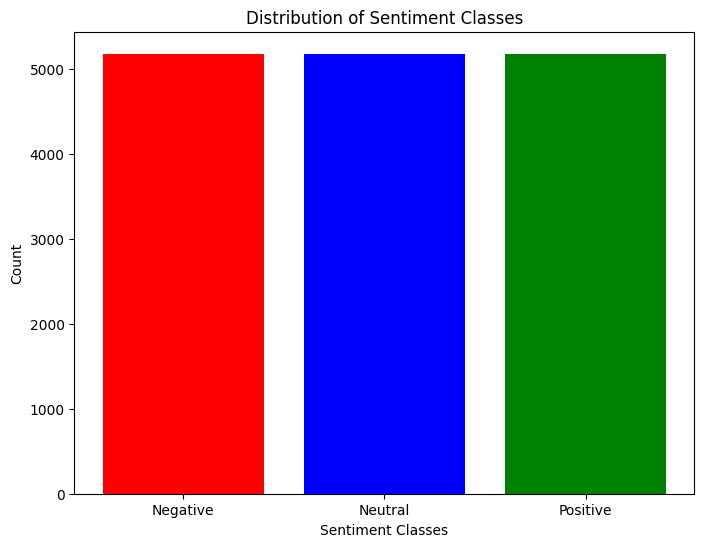

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Negative', 'Neutral', 'Positive']
values = [5180, 5180, 5180]  # Assuming the remaining data is positive

# Create the chart
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']  # Colors for each class
plt.bar(labels, values, color=colors)

# Labeling the chart
plt.xlabel('Sentiment Classes')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')

# Show the chart
plt.show()

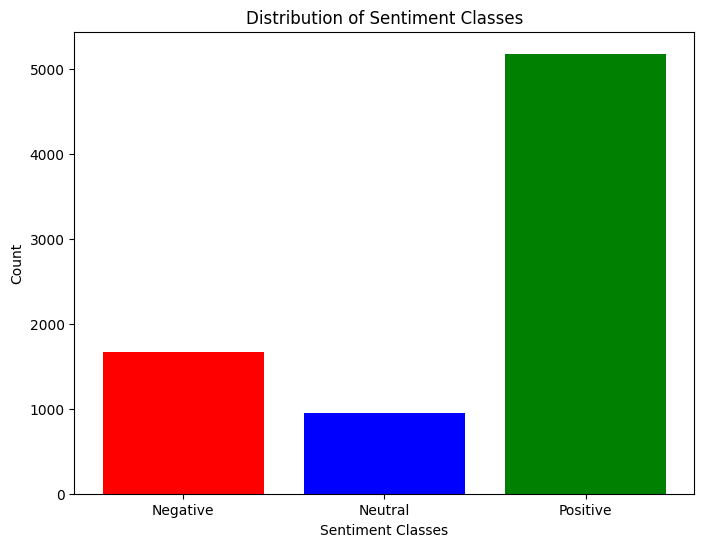

In [ ]:
import matplotlib.pyplot as plt

# Data
labels = ['Negative', 'Neutral', 'Positive']
values = [1670, 950, 7800 - (1670 + 950)]  # Assuming the remaining data is positive

# Create the chart
plt.figure(figsize=(8, 6))
colors = ['red', 'blue', 'green']  # Colors for each class
plt.bar(labels, values, color=colors)

# Labeling the chart
plt.xlabel('Sentiment Classes')
plt.ylabel('Count')
plt.title('Distribution of Sentiment Classes')

# Show the chart
plt.show()

In [ ]:
import requests
from bs4 import BeautifulSoup

# Step 3: Specify the URL of the reviews page
url = "https://www.bestbuy.com/site/reviews/samsung-27-8-cu-ft-4-door-french-door-refrigerator-with-food-showcase-fingerprint-resistant-black-stainless-steel/6323228"  # Replace this with the actual URL you want to scrape

# Step 4: Send a GET request to the website to retrieve the HTML content
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}
response = requests.get(url, headers=headers)

# Step 5: Parse the HTML content with BeautifulSoup
soup = BeautifulSoup(response.content, 'html.parser')

# Step 6: Extract reviews using a CSS selector that matches the review elements
reviews = []
# Assuming the reviews are in <div> tags with class 'review-content' - replace as necessary
review_elements = soup.find_all('div', class_='review-content')

# Step 7: Iterate over review elements and extract the text
for review in review_elements:
    reviews.append(review.text.strip())

# Step 8: Display the reviews (print first 5 reviews)
print(reviews[:5])


In [ ]:



# Preprocessing
X = dataset['review_text']
y = dataset['sentiment']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text data to TF-IDF features for traditional models
vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train).toarray()
X_test_tfidf = vectorizer.transform(X_test).toarray()

# Dictionary to store model results
results = {}

# Function to calculate metrics
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred, average='weighted')
    results[model_name] = [accuracy, precision, recall, f1]

# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train_tfidf, y_train)
y_pred_rf = rf.predict(X_test_tfidf)
evaluate_model(y_test, y_pred_rf, 'Random Forest')

# Decision Tree
dt = DecisionTreeClassifier()
dt.fit(X_train_tfidf, y_train)
y_pred_dt = dt.predict(X_test_tfidf)
evaluate_model(y_test, y_pred_dt, 'Decision Tree')

# Adaboost
ab = AdaBoostClassifier()
ab.fit(X_train_tfidf, y_train)
y_pred_ab = ab.predict(X_test_tfidf)
evaluate_model(y_test, y_pred_ab, 'Adaboost')

# CNN
cnn_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=5000),
    Conv1D(filters=64, kernel_size=5, activation='relu'),
    GlobalMaxPooling1D(),
    Dense(64, activation='relu'),
    Dense(1, activation='sigmoid')
])
cnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
cnn_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, verbose=1)
y_pred_cnn = cnn_model.predict(X_test_tfidf).round().astype(int)
evaluate_model(y_test, y_pred_cnn, 'CNN')

# LSTM
lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=5000),
    LSTM(128),
    Dense(1, activation='sigmoid')
])
lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
lstm_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, verbose=1)
y_pred_lstm = lstm_model.predict(X_test_tfidf).round().astype(int)
evaluate_model(y_test, y_pred_lstm, 'LSTM')

# Bidirectional LSTM
bi_lstm_model = Sequential([
    Embedding(input_dim=5000, output_dim=128, input_length=5000),
    Bidirectional(LSTM(128)),
    Dense(1, activation='sigmoid')
])
bi_lstm_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
bi_lstm_model.fit(X_train_tfidf, y_train, epochs=5, batch_size=32, verbose=1)
y_pred_bi_lstm = bi_lstm_model.predict(X_test_tfidf).round().astype(int)
evaluate_model(y_test, y_pred_bi_lstm, 'Bidirectional LSTM')

# BERT
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
def encode_texts(texts):
    return bert_tokenizer(list(texts), padding=True, truncation=True, return_tensors='tf')
X_train_bert = encode_texts(X_train)
X_test_bert = encode_texts(X_test)

bert_model = TFBertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)
bert_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
                   loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                   metrics=['accuracy'])
bert_model.fit(X_train_bert['input_ids'], y_train, epochs=3, batch_size=8)
y_pred_bert = tf.argmax(bert_model.predict(X_test_bert['input_ids']).logits, axis=1).numpy()
evaluate_model(y_test, y_pred_bert, 'BERT')

# Print results
results_df = pd.DataFrame(results, index=['Accuracy', 'Precision', 'Recall', 'F1 Score']).T
print(results_df)
